In [2]:
import pandas as pd
df = pd.read_csv('OnlineRetail.csv', parse_dates=['InvoiceDate'], infer_datetime_format=True ) # This instructs pandas to try to automatically infer the format of the date values in the 'InvoiceDate' column.
df


C:\Users\Sarah\AppData\Local\Temp\ipykernel_14932\1913392484.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('OnlineRetail.csv', parse_dates=['InvoiceDate'], infer_datetime_format=True ) # This instructs pandas to try to automatically infer the format of the date values in the 'InvoiceDate' column.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [3]:
# data cleaning
# drop null rows in column CustomerID
# change InvoiceNo and CustomerID to str
# drop null rows in Description column

df.dropna(axis=0, subset=['Description'], inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df['CustomerID'] = df['CustomerID'].astype('str')
df.dropna(axis=0,subset=['CustomerID'], inplace=True)
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [4]:
# we calculate an aggregate metric(mean, sum product) indicating how many orders were placed by each customer.
import numpy as np
n_orders = df.groupby(['CustomerID'])['InvoiceNo'].unique()
n_orders

CustomerID
12346.0       2
12347.0       7
12348.0       4
12349.0       1
12350.0       1
           ... 
18281.0       1
18282.0       3
18283.0      16
18287.0       3
nan        2256
Name: InvoiceNo, Length: 4373, dtype: int64

In [5]:
# find the % of customers ordered more than once.
mult_orders_perc = np.sum(n_orders > 1) / df['CustomerID'].nunique()
# This calculates the percentage of customers with multiple orders by dividing the number of customers with multiple orders by the total number of customers and calculates the total number of unique customer IDs in the DataFrame using nunique().
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

69.97% of customers ordered more than once.


C:\Users\Sarah\AppData\Local\Temp\ipykernel_14932\2094042401.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(n_orders, kde=False, hist=True)


[Text(0.5, 1.0, 'Distribution of number of orders per customer'),
 Text(0.5, 0, '# of orders'),
 Text(0, 0.5, '# of customers')]

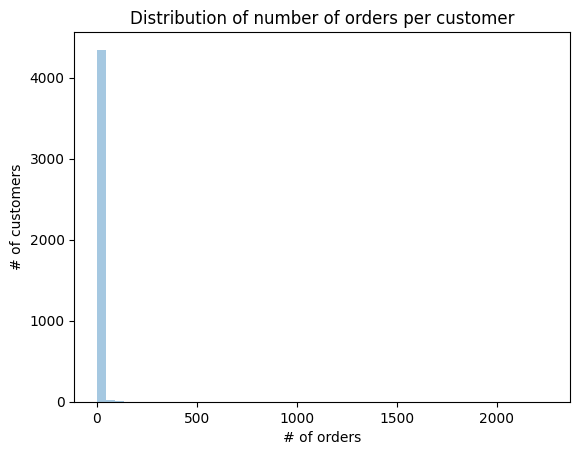

In [6]:
# We create a seaborn Plot to show number by numbe of orders.
#  distplot - distribution of a single variable.
# hist=True the function will generate a histogram to represent the distribution of the number of orders.
# disabling the KDE plot and focusing solely on the histogram
import seaborn as sns
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers')

In [7]:
#step 1: we keep only the relevant columns and drop duplicated values — one order (indicated by InvoiceNo) can contain multiple items
df = df[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()
df

,CustomerID,InvoiceNo,InvoiceDate
0,17850.0,536365,2010-12-01 08:26:00
7,17850.0,536366,2010-12-01 08:28:00
9,13047.0,536367,2010-12-01 08:34:00
21,13047.0,536368,2010-12-01 08:34:00
25,13047.0,536369,2010-12-01 08:35:00
...,...,...,...
541865,13777.0,581583,2011-12-09 12:23:00
541867,13777.0,581584,2011-12-09 12:25:00
541869,15804.0,581585,2011-12-09 12:31:00
541890,13113.0,581586,2011-12-09 12:49:00


In [9]:
# step 2: we create the cohort/group and order_month variables. The first one indicates the monthly cohort based on the first purchase date (calculated per customer). The latter one is the truncated month of the purchase date.
df['order_month'] = df['InvoiceDate'].dt.to_period('M')

df['cohort'] = df.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M') 
df.tail(10)

,CustomerID,InvoiceNo,InvoiceDate,order_month,cohort
541768,12713.0,581578,2011-12-09 12:16:00,2011-12,2011-12
541806,17581.0,581579,2011-12-09 12:19:00,2011-12,2010-12
541836,12748.0,581580,2011-12-09 12:20:00,2011-12,2010-12
541860,17581.0,581581,2011-12-09 12:20:00,2011-12,2010-12
541863,17581.0,581582,2011-12-09 12:21:00,2011-12,2010-12
541865,13777.0,581583,2011-12-09 12:23:00,2011-12,2010-12
541867,13777.0,581584,2011-12-09 12:25:00,2011-12,2010-12
541869,15804.0,581585,2011-12-09 12:31:00,2011-12,2011-05
541890,13113.0,581586,2011-12-09 12:49:00,2011-12,2010-12
541894,12680.0,581587,2011-12-09 12:50:00,2011-12,2011-08


In [11]:
# Then, we aggregate the data per cohort and order_month and count the number of unique customers in each group. Additionally, we add the period_number, which indicates the number of periods between the cohort month and the month of the purchase.
from operator import attrgetter #  This function is used to extract specific attributes from objects.
df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)
# agg applies an aggregation function(adding ) within the groupby operation.
# ensures both the original grouping columns (cohort and order_month) and the newly created column (n_customers) are retained as columns in the new DataFrame named df_cohort.
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
df_cohort
# we have grouped customers by cohort and month, calculated the number of customers in each group, and then added a new column indicating the number of months that have passed since the cohort's acquisition for each customer-month combination. This allows for further analysis of customer behavior within cohorts over time.

,cohort,order_month,n_customers,period_number
0,2010-12,2010-12,949,0
1,2010-12,2011-01,363,1
2,2010-12,2011-02,318,2
3,2010-12,2011-03,368,3
4,2010-12,2011-04,342,4
...,...,...,...,...
86,2011-10,2011-11,93,1
87,2011-10,2011-12,46,2
88,2011-11,2011-11,321,0
89,2011-11,2011-12,43,1


In [12]:
# The next step is to pivot the df_cohort table in a way that each row contains information about a given cohort and each column contains values for a certain period.
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,949.0,363.0,318.0,368.0,342.0,377.0,361.0,337.0,337.0,375.0,355.0,475.0,261.0
2011-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# To obtain the retention matrix, we need to divide the values each row by the row's first value, which is actually the cohort size — all customers who made their first purchase in the given month.
cohort_size = cohort_pivot.iloc[:,0]
#iloc used to access and manipulate data in a tabular format.
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
# performs element-wise division. performs element-wise division. axis = 0: This specifies that the division is performed along the rows
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1.0,0.382508,0.335090,0.387777,0.360379,0.397260,0.380400,0.355111,0.355111,0.395153,0.374078,0.500527,0.275026
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


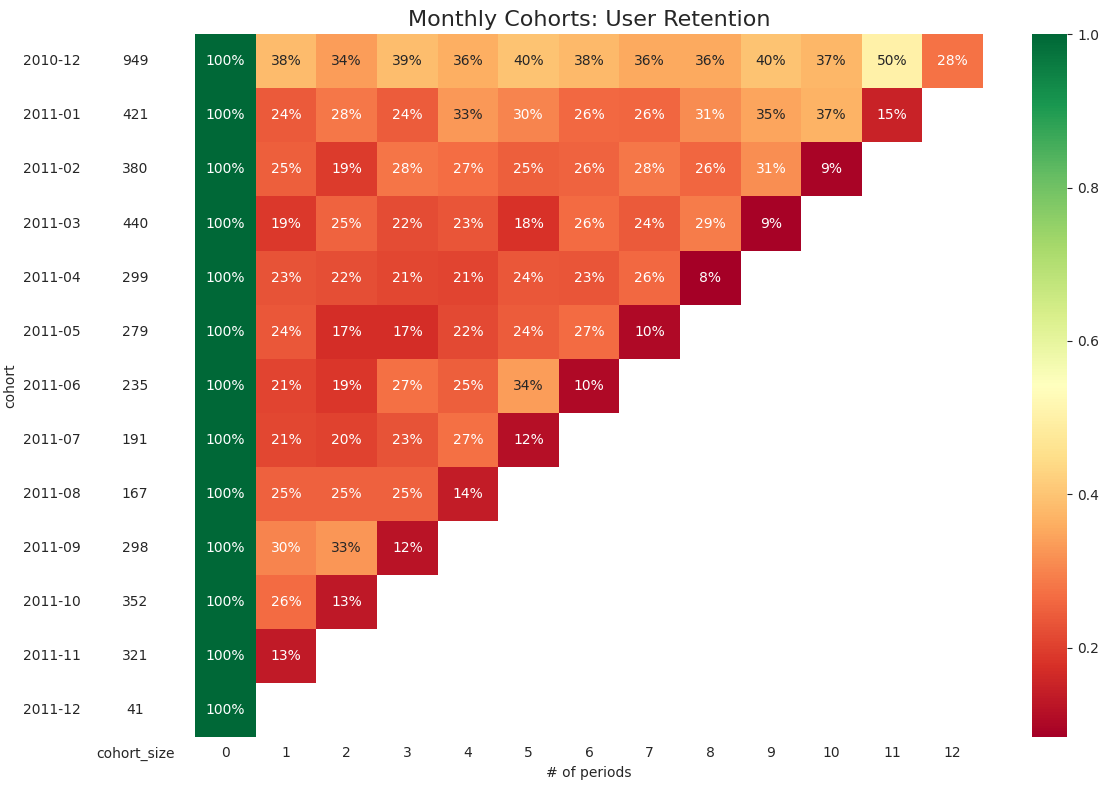

In [14]:
# when a dataframe is in form of a matrix, them we use heatmap or pairplot graphs
# Lastly, we plot the retention matrix as a heatmap. 
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [ ]:
# we can see that therez is a sharp drop-off in the second month (indexed as 1) already, on average around 80% of customers do not make any purchase in the second month. The first cohort (2010–12) seems to be an exception and performs surprisingly well as compared to the other ones. A year after the first purchase, there is a 50% retention. This might be a cohort of dedicated customers, because 50% of them have retained